***Property Auction Analysis to find Auction Bid Minimum and Maximum for 2025 Auction***
1. Using Tesseract OCR and Poppler, convert PDF images to string (text) and then extract the text
2. Conduct preprocessing functions to remove unnecessary lines, whitespace and correct some common errors
3. Review the OCR text for readability
4. Extract structured data for Key Fields: Parcel Number, Date Sold, Resale Certification, Bidder Number, Deed Name, Bid Amount, Trust Deposit Amount, Surplus Amount
4A.  Fix noted issues in Deed Names, Bid Amounts, Trust Deposits and Surplus Amounts
7. Checking the list lengths and Extract Fields into Rows
8. Create a DataFrame
9. Conduct Descriptive Analysis

***Import Libraries***

pytesseract for OCR

pdf2image for converting PDF pages to images

re for regex-based text cleaning

cv2 for converting image to grayscale and sharpening

PIL

In [3]:
import pytesseract
from pdf2image import convert_from_path
import re
import os
import pandas as pd
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

***1. Using Tesseract OCR and Poppler, convert PDF images to string (text) and then extract the text***

In [5]:
#Set Tesseract-OCR path  
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

In [6]:
#Convert PDF pages 4 onward (skipping the first three pages)
pdf_path = r"C:\Users\lisac\Tulsa Property Auction Analysis\02 Data\Original Data\Tulsa_County_Book_of_Sale_2024.pdf"
pages = convert_from_path(pdf_path, dpi=300, first_page=4)

In [7]:
#Process each page, converting the PDF images to string (text)
extracted_text = ""
for page in pages:
    extracted_text += pytesseract.image_to_string(page) + "\n"

***2. Conduct preprocessing functions to remove unnecessary lines, whitespace and correct some common errors***

In [9]:
#--- Preprocessing Functions removing unnecessary lines, whitespace, correcting common errors ---

def remove_unwanted_lines(text):
    """Remove known repeating headers and footers from OCR text."""
    lines = text.splitlines()
    cleaned_lines = []
    
    for line in lines:
        line = line.strip()
        if not line:
            continue
        if any(keyword in line.upper() for keyword in [
            "TULSA COUNTY TREASURER",
            "PAGE", 
            "RUN DATE", 
            "RETURN OF 2024 JUNE RESALE AUCTION", 
            "RESALE JOURNAL OF PROCEEDINGS",
            "THIS PROGRAM WAS RUN", 
            "REPORT IS IN ASCENDING PARCEL NUMBER ORDER",
            "TM2336-R01"
        ]):
            continue  # Skip this line
        cleaned_lines.append(line)
    
    return "\n".join(cleaned_lines)

def normalize_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def correct_common_ocr_errors(text):
    corrections = {
        '0O': '00',  # Example corrections; update as needed
        'lO': '10',
        'I0': '10',
        '5,5O0.00': '5,500.00'
    }
    for wrong, right in corrections.items():
        text = text.replace(wrong, right)
    return text

def preprocess_ocr_text(raw_text):
    text = remove_unwanted_lines(raw_text)
    text = normalize_whitespace(text)
    text = correct_common_ocr_errors(text)
    return text

***3. Review the OCR text for readability***

In [11]:
#Process the extracted text
processed_text = preprocess_ocr_text(extracted_text)
print("Processed OCR Text:\n", processed_text)

Processed OCR Text:
 TM2336-RO1 PARCEL NUMBER DATE SOLD RESALE CERTIFICATE NUMBER: LEGAL DESCRIPTION SUBDIVISION TAXING UNIT: TIA ADDITIONAL LEGAL PARCEL NUMBER DATE SOLD RESALE CERTIFICATE NUMBER: LEGAL DESCRIPTION SUBDIVISION TAXING UNIT: TIA ADDITIONAL LEGAL 06/26/24 10:17:59 2024 THRU JUNE 12, 00500-92-02-34510 06/10/24 2100027 ALL THAT PRT LT 1 LYING N OF FIRST ST ADJ TO FRISCO RR BLK 95 TULSA-ORIGINAL TOWN AN ADDITION TO THE CITY OF TULSA, TULSA COUNTY, STATE OF OKLAHOMA, ACCORDING TO THE LAST GOVERNMENT SURVEY THEREOF 01725-03-29-00310 06/10/24 2100145 LT 10 BLK 2 ANELEN HGTS ADDN AN ADDITION TO THE CITY OF TULSA, TULSA COUNTY, STATE OF OKLAHOMA, ACCORDING TO THE LAST GOVERNMENT SURVEY THEREOF BIDDER NUMBER: DEED NAME: 2024 311 PAUL WADE WILLIAMS TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1: NOTATION 2: BIDDER NUMBER: DEED NAME: [ NUMBER: [ TOTAL SURPLUS AMOUNT ISMENE RIVERA TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1: NOTATION 2: [ NUMBER: [ TOTAL SURPLUS AMO

In [12]:
#Verify the OCR output, first 10000 characters only
print("Processed OCR Text Sample:\n", processed_text[:1000])

Processed OCR Text Sample:
 TM2336-RO1 PARCEL NUMBER DATE SOLD RESALE CERTIFICATE NUMBER: LEGAL DESCRIPTION SUBDIVISION TAXING UNIT: TIA ADDITIONAL LEGAL PARCEL NUMBER DATE SOLD RESALE CERTIFICATE NUMBER: LEGAL DESCRIPTION SUBDIVISION TAXING UNIT: TIA ADDITIONAL LEGAL 06/26/24 10:17:59 2024 THRU JUNE 12, 00500-92-02-34510 06/10/24 2100027 ALL THAT PRT LT 1 LYING N OF FIRST ST ADJ TO FRISCO RR BLK 95 TULSA-ORIGINAL TOWN AN ADDITION TO THE CITY OF TULSA, TULSA COUNTY, STATE OF OKLAHOMA, ACCORDING TO THE LAST GOVERNMENT SURVEY THEREOF 01725-03-29-00310 06/10/24 2100145 LT 10 BLK 2 ANELEN HGTS ADDN AN ADDITION TO THE CITY OF TULSA, TULSA COUNTY, STATE OF OKLAHOMA, ACCORDING TO THE LAST GOVERNMENT SURVEY THEREOF BIDDER NUMBER: DEED NAME: 2024 311 PAUL WADE WILLIAMS TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1: NOTATION 2: BIDDER NUMBER: DEED NAME: [ NUMBER: [ TOTAL SURPLUS AMOUNT ISMENE RIVERA TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1: NOTATION 2: [ NUMBER: [ TOTAL SURP

Observation:  The OCR text is cleaned and readable.  The text has been extracted correctly from the PDF images.  

***4. Extract structured data for Key Fields: Parcel Number, Date Sold, Resale Certification, Bidder Number, Deed Name, Bid Amount, Trust Deposit Amount, Surplus Amount***

In [15]:
#Define regex patterns
parcel_number_pattern = r"(\d{5}-\d{2}-\d{2}-\d{5})"
date_sold_pattern = r"(\d{2}/\d{2}/\d{2})"
resale_cert_pattern = r"(\d{7})"
bidder_number_pattern = r"BIDDER NUMBER:\s*(\d+)"
deed_name_pattern = r"DEED NAME:\s*([\w\s]+)"
bid_amount_pattern = r"BID AMOUNT\s*([\d,]+\.\d{2})"
trust_deposit_total_pattern = r"TRUST DEPOSIT TOTAL\s*([\d,]+\.\d{2})"
net_surplus_amount_pattern = r"NET SURPLUS AMOUNT\s*([\d,]+\.\d{2})"

In [16]:
#Apply regex
parcel_numbers = re.findall(parcel_number_pattern, processed_text)
dates_sold = re.findall(date_sold_pattern, processed_text)
bidder_numbers = re.findall(bidder_number_pattern, processed_text)
deed_names = re.findall(deed_name_pattern, processed_text)
bid_amounts = re.findall(bid_amount_pattern, processed_text)
trust_deposit_totals = re.findall(trust_deposit_total_pattern, processed_text)
net_surplus_amounts = re.findall(net_surplus_amount_pattern, processed_text)

In [17]:
#Print sample extractions
print("Parcel Numbers:", parcel_numbers[:5])
print("Dates Sold:", dates_sold[:5])
print("Bidder Numbers:", bidder_numbers[:5])
print("Deed Names:", deed_names[:5])
print("Bid Amounts:", bid_amounts[:5])
print("Trust Deposit Totals:", trust_deposit_totals[:5])
print("Net Surplus Amounts:", net_surplus_amounts[:5])

Parcel Numbers: ['00500-92-02-34510', '01725-03-29-00310', '01900-03-19-01200', '02675-03-32-00870', '02675-03-32-00980']
Dates Sold: ['06/26/24', '06/10/24', '06/10/24', '06/10/24', '06/26/24']
Bidder Numbers: ['235', '326', '326', '290', '290']
Deed Names: ['2024 311 PAUL WADE WILLIAMS TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1', ' ', 'EVERGREEN PROPERTIES 1313 LLC TRUST DEPOSIT NUMBER', 'EVERGREEN PROPERTIES 1313 LLC TRUST DEPOSIT NUMBER', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC TRUST DEPOSIT NUMBER']
Bid Amounts: ['190,000.00']
Trust Deposit Totals: ['5,870.25', '32,323.25', '4,840.00', '9,546.75', '10,296.75']
Net Surplus Amounts: ['31,125.01', '3,964.67', '6,805.75', '22,653.43', '56,606.37']


Observations:  

Parcel numbers, dates sold and resale certificate information look good.  

Noted issues to fix:

Deed Names: grabbing too much information

Bid Amounts: only one bid amount pulled.  Need a broader, more accurate regex pattern to pull these amounts

Trust Deposits and Surplus Amounts:  no information pulled at all

***4A. Fix noted issues in Deed Names, Bid Amounts, Trust Deposits and Surplus Amounts by updating regex patterns***

***DEED NAMES***

In [21]:
#Extract only the deed name up to the next key word
deed_name_pattern = r"DEED NAME:\s*([A-Z0-9\s&.,'-]+?)\s+(TRUST DEPOSIT|BID AMOUNT)"

In [22]:
#Check to see what is being pulled
print("Deed Names:", deed_names[:10])

Deed Names: ['2024 311 PAUL WADE WILLIAMS TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1', ' ', 'EVERGREEN PROPERTIES 1313 LLC TRUST DEPOSIT NUMBER', 'EVERGREEN PROPERTIES 1313 LLC TRUST DEPOSIT NUMBER', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC TRUST DEPOSIT NUMBER', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC TRUST DEPOSIT NUMBER', 'ISMENE RIVERA TRUST DEPOSIT NUMBER', 'RESALE CERTIFICATE NUMBER', 'RESALE CERTIFICATE NUMBER', 'GC REAL ESTATE LLC TRUST DEPOSIT NUMBER']


Observation: still pulling too much information.  Regex does not know where to stop because it's pulling "Resale Certification Number" and "Trust Deposit Number" Need to amend regex code.

In [24]:
#Amended regex code by including [A-Z0-9\s&.,'-]+? to capture the actual name and (?=...) to lookahead and stop before any of those keywords
deed_name_pattern = r"DEED NAME:\s*([A-Z0-9\s&.,'-]+?)(?=\s+(TRUST DEPOSIT|RESALE CERTIFICATE|BID AMOUNT|NUMBER|NET|$))"
matches = re.findall(deed_name_pattern, processed_text)
deed_names = [match[0].strip() for match in matches]

In [25]:
#Check to see what is being pulled
print("Deed Names:", deed_names[:10])

Deed Names: ['2024 311 PAUL WADE WILLIAMS', 'EVERGREEN PROPERTIES 1313 LLC', 'EVERGREEN PROPERTIES 1313 LLC', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC', 'ISMENE RIVERA', 'RESALE CERTIFICATE', 'RESALE CERTIFICATE', 'GC REAL ESTATE LLC', 'OAKLEY PROPERTIES, L.L.C']


Observation: Pulling RESALE CERTIFICATE.  Amending the deed_name_pattern code to be more flexible by changing "\s+" to "\s*"

In [27]:
#Amended regex code by changing "\s+" to "\s*"
deed_name_pattern = r"DEED NAME:\s*([A-Z0-9\s&.,'-]+?)(?=\s*(TRUST DEPOSIT|RESALE CERTIFICATE|BID AMOUNT|NUMBER|NET|$))"
matches = re.findall(deed_name_pattern, processed_text)
deed_names = [match[0].strip() for match in matches]

In [28]:
#Remove any false positives that are not actual deed names
invalid_deed_keywords = ['RESALE CERTIFICATE', 'DEED NAME', 'TRUST DEPOSIT', 'BID AMOUNT', 'NUMBER', 'NET']
deed_names = [name for name in deed_names if all(keyword not in name for keyword in invalid_deed_keywords)]

In [29]:
#Cleanup for false positives
invalid_deed_keywords = ['RESALE CERTIFICATE', 'DEED NAME', 'TRUST DEPOSIT', 'BID AMOUNT', 'NUMBER', 'NET']
deed_names = [name for name in deed_names if all(keyword not in name for keyword in invalid_deed_keywords)]

In [30]:
#Check to see what is being pulled
print("Cleaned Deed Names:", deed_names[:10])

Cleaned Deed Names: ['2024 311 PAUL WADE WILLIAMS', 'EVERGREEN PROPERTIES 1313 LLC', 'EVERGREEN PROPERTIES 1313 LLC', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC', 'ISMENE RIVERA', 'GC REAL ESTATE LLC', 'OAKLEY PROPERTIES, L.L.C', 'OAKLEY PROPERTIES, L.L.C', 'OAKLEY PROPERTIES, L.L.C']


Observation:  I AM ON FIRE WITH THIS!!!!!  Regex amendments worked and deed names look accurate

***BID AMOUNT - EXTRACTION***

In [33]:
#Cleaning up what is pulled for BID AMOUNT
bid_amount_pattern = r"BID AMOUNT\s*\$?([0-9]{1,3}(?:,[0-9]{3})*\.\d{2})" 
    #\s* allows for optional spaces between "BID AMOUNT" and the number
    #\$? optional dollar sign.
    #([0-9]{1,3}(?:,[0-9]{3})*\.\d{2}) — matches numbers like 5,500.00, 190,000.00, etc.
bid_matches = re.findall(bid_amount_pattern, processed_text)
bid_amounts = [amount.strip() for amount in bid_matches]

In [34]:
#Check to see what is being pulled
print("Bid Amounts:", bid_amounts[:100])

Bid Amounts: ['190,000.00']


Observation:  only one amount is coming up, that means the formatting around the other "BID AMOUNT" lines is inconsistent.  This will need to be cleaned up 

In [36]:
#First, let's look at how other BID AMOUNTS are formatted
for line in processed_text.splitlines():
    if "BID AMOUNT" in line:
        print(line)

TM2336-RO1 PARCEL NUMBER DATE SOLD RESALE CERTIFICATE NUMBER: LEGAL DESCRIPTION SUBDIVISION TAXING UNIT: TIA ADDITIONAL LEGAL PARCEL NUMBER DATE SOLD RESALE CERTIFICATE NUMBER: LEGAL DESCRIPTION SUBDIVISION TAXING UNIT: TIA ADDITIONAL LEGAL 06/26/24 10:17:59 2024 THRU JUNE 12, 00500-92-02-34510 06/10/24 2100027 ALL THAT PRT LT 1 LYING N OF FIRST ST ADJ TO FRISCO RR BLK 95 TULSA-ORIGINAL TOWN AN ADDITION TO THE CITY OF TULSA, TULSA COUNTY, STATE OF OKLAHOMA, ACCORDING TO THE LAST GOVERNMENT SURVEY THEREOF 01725-03-29-00310 06/10/24 2100145 LT 10 BLK 2 ANELEN HGTS ADDN AN ADDITION TO THE CITY OF TULSA, TULSA COUNTY, STATE OF OKLAHOMA, ACCORDING TO THE LAST GOVERNMENT SURVEY THEREOF BIDDER NUMBER: DEED NAME: 2024 311 PAUL WADE WILLIAMS TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1: NOTATION 2: BIDDER NUMBER: DEED NAME: [ NUMBER: [ TOTAL SURPLUS AMOUNT ISMENE RIVERA TRUST DEPOSIT BID AMOUNT TRUST DEPOSIT NET NOTATION 1: NOTATION 2: [ NUMBER: [ TOTAL SURPLUS AMOUNT 240117 240118 5,5

Observation: the BID AMOUNT field is clearly visible in the actual PDF, but Tesseract OCR is not extracting the numerical values, the issue may be due to:

The OCR misinterpreting numbers due to formatting

The BID AMOUNT being outside of the standard text flow (e.g., in a separate column or table)

Tesseract’s default mode not handling structured tabular data properly

Tesseract’s image_to_string() reads text linearly, which may cause it to skip structured tables or numbers. Instead, we can use image_to_data() to get detailed positional data and locate BID AMOUNT values.

***This next section of code will change the image from String to Data and then look for the numerical values***

In [39]:
#Convert image to structured OCR data
ocr_data = pytesseract.image_to_data(pages[0], output_type=pytesseract.Output.DATAFRAME)

In [40]:
#Display available OCR columns
print(ocr_data.head())

   level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
0      1         1          0        0         0         0     0    0   3300   
1      2         1          1        0         0         0   152   96    211   
2      3         1          1        1         0         0   152   96    211   
3      4         1          1        1         1         0   152   96    211   
4      5         1          1        1         1         1   152   96    211   

   height       conf        text  
0    2550  -1.000000         NaN  
1      61  -1.000000         NaN  
2      61  -1.000000         NaN  
3      24  -1.000000         NaN  
4      24  88.199158  TM2336-RO1  


In [41]:
#Filter rows where 'text' column contains 'BID AMOUNT' (case insensitive)
bid_rows = ocr_data[ocr_data['text'].str.contains('BID AMOUNT', case=False, na=False)]

In [42]:
#If BID AMOUNT is found, extract the next numerical values from OCR
if not bid_rows.empty:
    for index, row in bid_rows.iterrows():
        # Find the next row that contains numbers (assumed to be bid amounts)
        bid_value_row = ocr_data.iloc[index + 1] if index + 1 < len(ocr_data) else None
        if bid_value_row is not None and bid_value_row['text'].isdigit():
            print(f"BID AMOUNT: {bid_value_row['text']}")

Observation: ocr_data.head() output shows mostly empty (NaN) or low-confidence (-1.000000) values.

This means Tesseract didn’t detect much readable text from the image.

The only detected text (TM2336-RO1), this number is not relevant to BID AMOUNT.

bid_rows is empty, meaning "BID AMOUNT" was not found anywhere in the OCR output.

I looked up why this could happen:
 - The text is formatted in a way Tesseract struggles with (e.g., tabular format, faint text).
 - OCR needs pre-processing (sharpening, grayscale, or binarization).

This next group of codes will be solely to improve the OCR quality.  I will do this by enhancing the image quality using grayscaling (cv2) and adaptive thresholds to improve the text contrast for OCR (PIL).

***BID AMOUNT - CORRECTION AND EXTRACTION***

***Step 1: Convert image to grayscale and sharpen***

In [45]:
#Convert the first page to an OpenCV image
image = np.array(pages[3])

In [46]:
#Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [47]:
#Apply adaptive thresholding to improve contrast
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

In [48]:
#Convert back to PIL image for Tesseract
processed_image = Image.fromarray(thresh)

In [49]:
#Save for debugging
processed_image.save("processed_sample_page.png")

In [50]:
#Run OCR again
ocr_data = pytesseract.image_to_data(processed_image, output_type=pytesseract.Output.DATAFRAME)

In [51]:
#Print some sample OCR output
print(ocr_data.head())

   level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
0      1         1          0        0         0         0     0    0   3300   
1      2         1          1        0         0         0  1651   98    126   
2      3         1          1        1         0         0  1651   98    126   
3      4         1          1        1         1         0  1651   98    126   
4      5         1          1        1         1         1  1651   98    126   

   height  conf text  
0    2550  -1.0  NaN  
1       2  -1.0  NaN  
2       2  -1.0  NaN  
3       2  -1.0  NaN  
4       2  95.0       


Observation:
OCR is still struggling to extract readable text.

The text column is mostly NaN (empty), meaning Tesseract couldn’t detect any numbers.

The conf (confidence score) is -1.0, which suggests very low confidence or complete failure in text recognition.

One detected value (95.0) in the confidence column, but no text or numbers.

This could be a formatting issue or unwanted noise being detected instead of text or numbers.

Since the grayscale and thresholding didn't improve text/number detection, I will try Page Segmentation Mode (PSM 6).  

PSM 6 will tell Tesseract to read the image as a uniform block of text (numbers).

In [53]:
#Run OCR again with improved config
ocr_data = pytesseract.image_to_data(processed_image, config='--psm 6', output_type=pytesseract.Output.DATAFRAME)

In [54]:
# Print sample output
print(ocr_data.head())

   level  page_num  block_num  par_num  line_num  word_num  left  top  width  \
0      1         1          0        0         0         0     0    0   3300   
1      2         1          1        0         0         0   150   88   2780   
2      3         1          1        1         0         0   150   88   2780   
3      4         1          1        1         1         0   152   88   2778   
4      5         1          1        1         1         1   152   88    211   

   height       conf         text  
0    2550  -1.000000          NaN  
1    1829  -1.000000          NaN  
2    1829  -1.000000          NaN  
3      41  -1.000000          NaN  
4      41  36.253403  TM2336-RO01  


Observation: 
The output shows that even with PSM 6, Tesseract is still not recognizing the BID AMOUNT values—it’s picking up the header text ("TM2336-RO01") and nothing else.

I looked this up and it could mean:
 - Tesseract isn’t detecting the numerical fields: The output has many rows with NaN text and low or negative confidence scores.

 - The BID AMOUNT region might be getting lost in the overall layout: If the numeric values are in a specific column or area of the page, Tesseract may be struggling to isolate that area in full-page OCR.

Next step, manually crop the bid amount so that Tesseract will only focus on and process that image for numeric values.

In [56]:
#Convert first page (page three in this PDF) to a numpy array (assuming pages[0] is your target page)
image_np = np.array(pages[3])

In [57]:
#Define the region coordinates for BID AMOUNT (adjust these values as needed)
x, y, w, h = 1200, 500, 400, 100  # example coordinates
cropped = image_np[y:y+h, x:x+w]

In [58]:
#Convert cropped region to grayscale
gray_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

In [59]:
#Optionally, apply thresholding to improve clarity
_, thresh_cropped = cv2.threshold(gray_cropped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [60]:
#Convert back to PIL image for OCR
cropped_image = Image.fromarray(thresh_cropped)

In [61]:
#Run OCR on cropped image with a config to focus on digits
custom_config = r'--psm 6 -c tessedit_char_whitelist=0123456789,.'  # focus on numbers and commas/periods
bid_amount_text = pytesseract.image_to_string(cropped_image, config=custom_config)

In [62]:
print("Extracted Bid Amount Text from Cropped Region:")
print(bid_amount_text)

Extracted Bid Amount Text from Cropped Region:



In [63]:
cropped_image.save(r"C:\Users\lisac\Tulsa Property Auction Analysis\04 Analysis\Visualizations\cropped_bid_amount.png")
print("Cropped image saved as 'cropped_bid_amount.png' in the specified folder.")

Cropped image saved as 'cropped_bid_amount.png' in the specified folder.


Observation of image:

Image was blank.  That could mean the region coordinates for the bid amount location are not correct.

Next step, save an entire page as a PNG image for reference / location of the BID AMOUNT

In [65]:
pages[3].save(r"C:\Users\lisac\Tulsa Property Auction Analysis\04 Analysis\Visualizations\page_0_full.png", "PNG")

***Step 2: Identify the coordinates on the PDF for the middle and bottom BID AMOUNTS for ONE PAGE***

***I started with Designer for help with cropping and coordinate location and then used PicPick, which was much more accurate***

In [67]:
# Middle region
x, y, w, h = 2448, 893, 208, 51
cropped_middle = image_np[y:y+h, x:x+w]

# Bottom region
x, y, w, h = 2445, 1664, 216, 48
cropped_bottom = image_np[y:y+h, x:x+w]

In [68]:
bid_text_middle = pytesseract.image_to_string(cropped_middle, config=custom_config)
bid_text_bottom = pytesseract.image_to_string(cropped_bottom, config=custom_config)

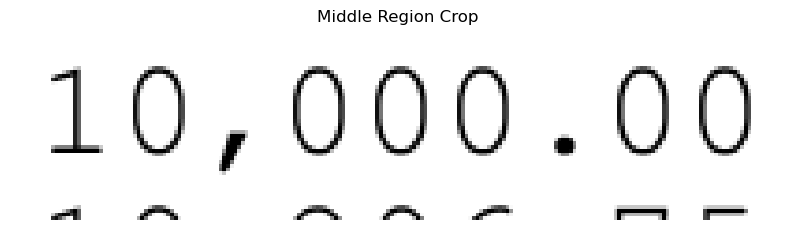

In [69]:
# Show cropped middle region
plt.figure(figsize=(10, 5))
plt.imshow(cropped_middle, cmap="gray")
plt.title("Middle Region Crop")
plt.axis("off")
plt.show()

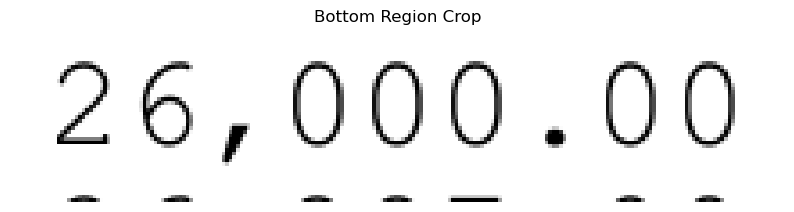

In [70]:
# Show cropped bottom region
plt.figure(figsize=(10, 5))
plt.imshow(cropped_bottom, cmap="gray")
plt.title("Bottom Region Crop")
plt.axis("off")
plt.show()

In [71]:
#Print the extracted text to confirm Tesseract recognized it
print("Middle Bid Amount Text:", bid_text_middle)
print("Bottom Bid Amount Text:", bid_text_bottom)

Middle Bid Amount Text: 10,000.00

Bottom Bid Amount Text: 26,000.00



Observation:  SUCCESS!!! I used an online image coordinate picker: PicPick to help me identify the exact coordinates on the page.  This was incredibly helpful because the Bid Amounts are in roughly the same area on each page of the PDF.  

Next Step:  Loop through all pages of the PDF and extract the Bid Amounts for the DataFrame.

***Step 3:  Loop through ALL pages in PDF and locate Bid Amounts based on coordinates previously identified***

In [74]:
bid_amounts = []

#Search for Bid Amounts on all pages of PDF
pages = convert_from_path(pdf_path, dpi=300, first_page=4)   

for page in pages:
    image_np = np.array(page)
    
    #Crop coordinates for middle and bottom regions  
    #Middle Region
    x_mid, y_mid, w, h = 2448, 893, 208, 51  
    cropped_mid = image_np[y_mid:y_mid+h, x_mid:x_mid+w]
    bid_text_mid = pytesseract.image_to_string(cropped_mid, config=custom_config).strip()
    
    #Bottom Region
    x_bot, y_bot, w, h = 2445, 1664, 216, 48  
    cropped_bot = image_np[y_bot:y_bot+h, x_bot:x_bot+w]
    bid_text_bot = pytesseract.image_to_string(cropped_bot, config=custom_config).strip()
    
    # Convert strings to float (if non-empty)
    for bid_text in [bid_text_mid, bid_text_bot]:
        if bid_text:
            try:
                bid_float = float(bid_text.replace(",", ""))
                bid_amounts.append(bid_float)
            except ValueError:
                print("Conversion failed for:", bid_text)

In [75]:
#Verify Bid_Amounts contains all the numeric bid amounts from the PDF
df = pd.DataFrame(bid_amounts, columns=["Bid Amount"])
print(df)

     Bid Amount
0        5500.0
1        8250.0
2        5600.0
3       32000.0
4        4500.0
..          ...
223     16000.0
224     16000.0
225     60500.0
226     47000.0
227        40.0

[228 rows x 1 columns]


Observation:  SUCCESS!  Looped through ALL the pages of the OCR and Bid Amounts were correct identified.

***Checking the list length and Extracting the fields into Rows***

In [142]:
#Checking list length
print("Parcel Numbers:", len(parcel_numbers))
print("Dates Sold:", len(dates_sold))
print("Bidder Numbers:", len(bidder_numbers))
print("Deed Names:", len(deed_names))
print("Bid Amounts:", len(bid_amounts))
print("Trust Deposit Totals:", len(trust_deposit_totals))
print("Net Surplus Amounts:", len(net_surplus_amounts))

Parcel Numbers: 228
Dates Sold: 205
Bidder Numbers: 220
Deed Names: 112
Bid Amounts: 228
Trust Deposit Totals: 62
Net Surplus Amounts: 45


Observation  
Parcel numbers and Bid Amounts match.  However, Dates Sold, Bidder Numbers, Deed Names, Trust Deposit Totals and Net Surplus Amounts do not.  This means those regex patterns didn’t match as many items as expected. 

Some common causes
OCR errors (weird characters, inconsistent spacing)

Pattern is too strict

The label I am trying to match on isn't always present or is slightly different (e.g., DEED NAME: might be missing or malformed)

Next Step, fix the regex fields one by one

In [172]:
#Fix Deed Name again
deed_name_pattern = r"DEED NAME:\s*([A-Z0-9\s&.,'-]+?)(?=\s*(TRUST DEPOSIT|RESALE CERTIFICATE|BID AMOUNT|NUMBER|NET|$))"
matches = re.findall(deed_name_pattern, processed_text)
deed_names = [match[0].strip() for match in matches]

In [174]:
#Remove any false positives that are not actual deed names
invalid_deed_keywords = ['RESALE CERTIFICATE', 'DEED NAME', 'TRUST DEPOSIT', 'BID AMOUNT', 'NUMBER', 'NET']
deed_names = [name for name in deed_names if all(keyword not in name for keyword in invalid_deed_keywords)]

In [176]:
#Cleanup for false positives
invalid_deed_keywords = ['RESALE CERTIFICATE', 'DEED NAME', 'TRUST DEPOSIT', 'BID AMOUNT', 'NUMBER', 'NET']
deed_names = [name for name in deed_names if all(keyword not in name for keyword in invalid_deed_keywords)]

In [178]:
#Check to see what is being pulled
print("Cleaned Deed Names:", deed_names[:10])

Cleaned Deed Names: ['2024 311 PAUL WADE WILLIAMS', 'EVERGREEN PROPERTIES 1313 LLC', 'EVERGREEN PROPERTIES 1313 LLC', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC', 'OKLAHOMA VENTURE CAPITAL PARTNERS LLC', 'ISMENE RIVERA', 'GC REAL ESTATE LLC', 'OAKLEY PROPERTIES, L.L.C', 'OAKLEY PROPERTIES, L.L.C', 'OAKLEY PROPERTIES, L.L.C']


In [180]:
print("Deed Names:", len(deed_names))

Deed Names: 112
